In [60]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from evaluate import test_k
from run import get_args
plt.style.use('seaborn-whitegrid')

In [61]:
tf.enable_eager_execution()
args = get_args()
filename = "results.csv"

if os.path.isfile(filename):
    df = pd.read_csv(filename)
else:
    k_values = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
    weights_accuracies, nodes_accuracies = test_k(args, k_values)
    df = pd.DataFrame({
        'k': k_values, 
        'weights_accuracies': [w.numpy() for w in weights_accuracies], 
        'nodes_accuracies': [n.numpy() for n in nodes_accuracies]
    })
    df.to_csv(filename)

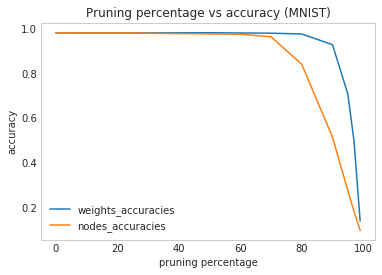

In [62]:
fig = plt.figure()
ax = plt.axes()

plt.plot(df['k'], df['weights_accuracies'])
plt.plot(df['k'], df['nodes_accuracies'])
ax.set(xlabel='pruning percentage', ylabel='accuracy')
plt.title("Pruning percentage vs accuracy (MNIST)")
ax.legend()
ax.grid()

## Results and discussion
We gathered our results by training a 5-layer feed-forward neural network with rectified activations for 20 epochs on the MNIST dataset.

From the results we can see that weight pruning achieves better accuracy after pruning compared to unit pruning. This results from the fine-grain pruning that individual weight pruning gives compared to unit pruning. Weight pruning allows you to find and keep the largest k% out of all weights, whereas unit pruning chooses the top k% of columns of the weight matrix (based on L2 norm) and deletes the entire column. A weight might be high w.r.t. its adjacent weights coming out of the same unit, but the L2 norm may be low for all outputs coming out of a single unit.

We hypothesize that we are able to prune smaller weights without much interference to the performance of our model because of how little it effects the overall error function. From analysis and approximation of the error term with a simple Taylor series(Le Cun et al., 1990), we see that loss is proportional to the square of the weights at each layer. This explains why we are able to delete small weights without much detriment to loss - small perturbations effect error quadratically. If our weights are small enough they will have little impact on the error of the network.

From previous work (Le Cun et al., 1990; Gomez et al., 2018), we know that networks with too many weights do not generalize well. We also know that networks with too few weights will not be robust enough to represent features in the training data. There are various schemes in achieving a sparse neural network (another example is regularization with a measure of model complexity). Another (slightly modified) scheme we have yet to try is targeted dropout (Gomez et al., 2018) where we stochastically prune weights during training.